In [1]:
import numpy as np
import pandas as pd
import sklearn as sl
import sklearn.preprocessing as preprocessing
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Churn_Modelling copy.csv to Churn_Modelling copy (3).csv


In [3]:
import pandas as pd
from io import StringIO

filename = list(uploaded.keys())[0]

df = pd.read_csv(StringIO(uploaded[filename].decode('utf-8')))


In [4]:
!pip install ydata-profiling
import ydata_profiling
ydata_profiling.ProfileReport(df)


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<Axes: xlabel='Exited', ylabel='EstimatedSalary'>

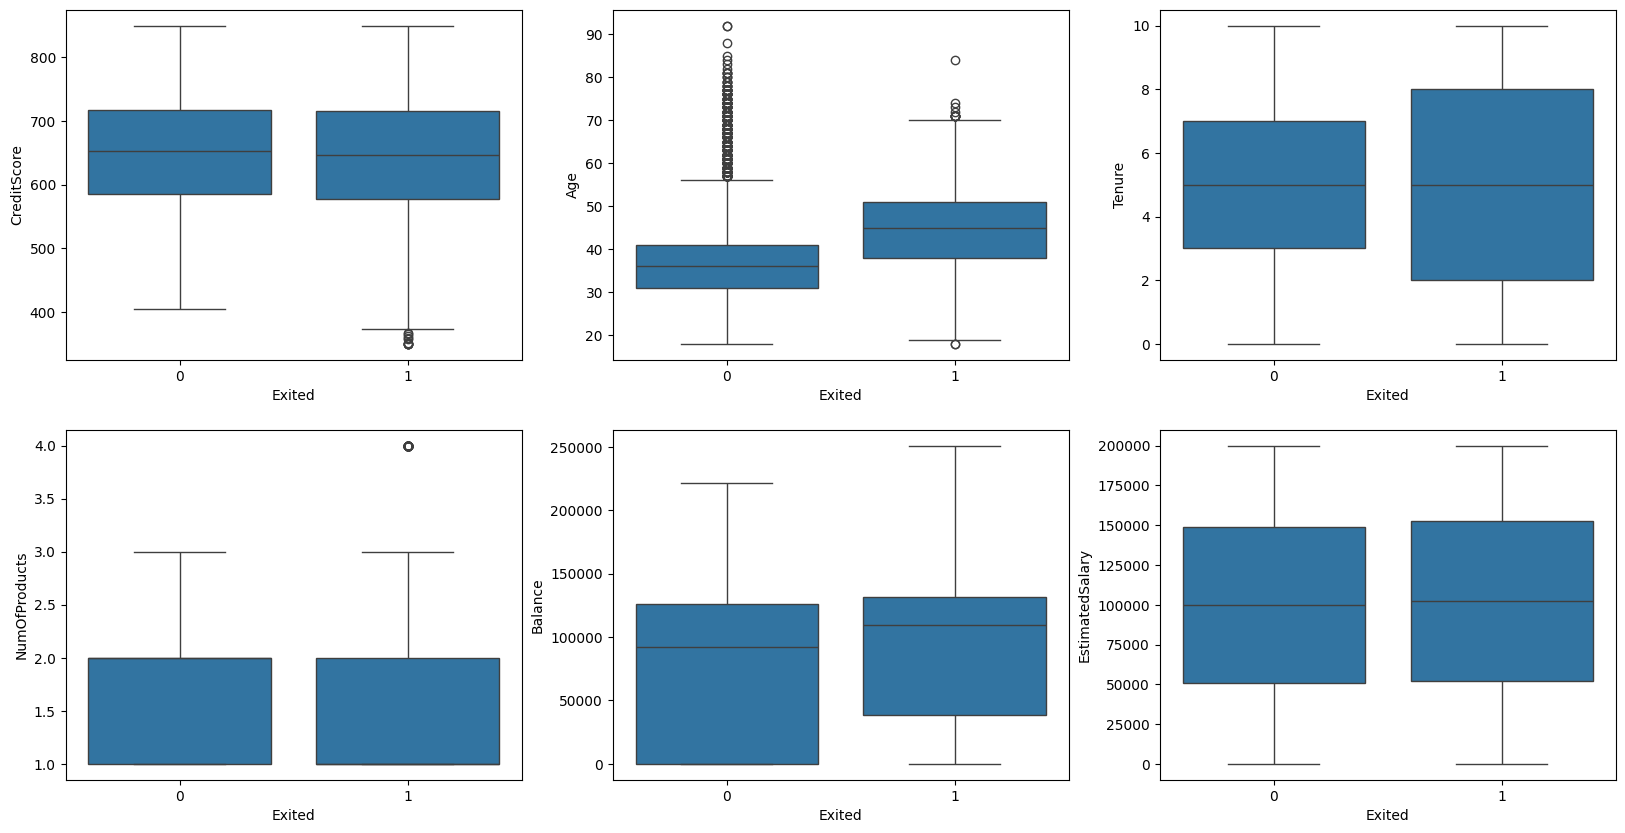

In [5]:
_,axss = plt.subplots(2,3, figsize=[20,10])
sns.boxplot(x='Exited', y ='CreditScore', data=df, ax=axss[0][0])
sns.boxplot(x='Exited', y ='Age', data=df, ax=axss[0][1])
sns.boxplot(x='Exited', y ='Tenure', data=df, ax=axss[0][2])
sns.boxplot(x='Exited', y ='NumOfProducts', data=df, ax=axss[1][0])
sns.boxplot(x='Exited', y ='Balance', data=df, ax=axss[1][1])
sns.boxplot(x='Exited', y ='EstimatedSalary', data=df, ax=axss[1][2])

In [6]:
y = df['Exited']
to_drop = ['RowNumber','CustomerId','Surname','Exited']
X = df.drop(to_drop, axis = 1)

In [7]:
cat_cols = X.columns[X.dtypes == 'object']
num_cols = X.columns[(X.dtypes == 'float64') | (X.dtypes == 'int64')]

In [8]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, stratify = y, random_state = 1)

In [9]:

from sklearn.preprocessing import OneHotEncoder

def OneHotEncoding(df, enc, categories):
  transformed = pd.DataFrame(enc.transform(df[categories]).toarray(), columns = enc.get_feature_names_out(categories))
  return pd.concat([df.reset_index(drop=True), transformed], axis=1).drop(categories, axis=1)

categories = ['Geography']
enc_ohe = OneHotEncoder()
enc_ohe.fit(X_train[categories])

X_train = OneHotEncoding(X_train, enc_ohe, categories)
X_test = OneHotEncoding(X_test, enc_ohe, categories)

In [10]:
from sklearn.preprocessing import OrdinalEncoder

categories = ['Gender']
enc_oe = OrdinalEncoder()
enc_oe.fit(X_train[categories])

X_train[categories] = enc_oe.transform(X_train[categories])
X_test[categories] = enc_oe.transform(X_test[categories])

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train[num_cols])

X_train[num_cols] = scaler.transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

classifier_logistic = LogisticRegression()

classifier_KNN = KNeighborsClassifier()

classifier_RF = RandomForestClassifier()

In [13]:
classifier_logistic.fit(X_train, y_train)


LogisticRegression()

In [14]:
classifier_KNN.fit(X_train, y_train)
classifier_KNN.predict(X_test)
classifier_KNN.score(X_test, y_test)

0.8336

In [15]:
classifier_RF.fit(X_train, y_train)
classifier_RF.predict(X_test)
classifier_RF.score(X_test, y_test)

0.8628

In [16]:
classifier_logistic.predict(X_test)
classifier_logistic.score(X_test, y_test)


0.8088

In [17]:
from sklearn.model_selection import GridSearchCV

def print_grid_search_metrics(gs):
    print ("Best score: " + str(gs.best_score_))
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(best_parameters.keys()):
        print(param_name + ':' + str(best_parameters[param_name]))

In [18]:
parameters = {
    'penalty':('l2','l1'),
    'C':(0.01, 0.05, 0.1, 0.2, 1)
}

Grid_LR = GridSearchCV(LogisticRegression(solver='liblinear'),parameters, cv = 5)
Grid_LR.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'),
             param_grid={'C': (0.01, 0.05, 0.1, 0.2, 1),
                         'penalty': ('l2', 'l1')})

In [19]:
print_grid_search_metrics(Grid_LR)


Best score: 0.8125333333333333
Best parameters set:
C:0.2
penalty:l1


In [20]:
best_LR_model = Grid_LR.best_estimator_
best_LR_model.predict(X_test)
best_LR_model.score(X_test, y_test)


0.81

In [21]:
parameters = {
    'n_neighbors':[1,3,5,7,9]
}
Grid_KNN = GridSearchCV(KNeighborsClassifier(),parameters, cv=5)
Grid_KNN.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 3, 5, 7, 9]})

In [22]:
print_grid_search_metrics(Grid_KNN)


Best score: 0.8433333333333334
Best parameters set:
n_neighbors:9


In [23]:
best_KNN_model = Grid_KNN.best_estimator_
best_KNN_model.predict(X_test)
best_KNN_model.score(X_test, y_test)


0.8428

In [24]:
parameters = {
    'n_estimators' : [60,80,100],
    'max_depth': [1,5,10]
}
Grid_RF = GridSearchCV(RandomForestClassifier(),parameters, cv=5)
Grid_RF.fit(X_train, y_train)
print_grid_search_metrics(Grid_RF)

Best score: 0.8645333333333334
Best parameters set:
max_depth:10
n_estimators:100


In [25]:
best_RF_model = Grid_RF.best_estimator_
best_RF_model.score(X_test, y_test)


0.864

In [26]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def cal_evaluation(classifier, cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    print (classifier)
    print ("Accuracy is: " + str(accuracy))
    print ("precision is: " + str(precision))
    print ("recall is: " + str(recall))
    print ()

def draw_confusion_matrices(confusion_matricies):
    class_names = ['Not','Churn']
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        cal_evaluation(classifier, cm)

In [27]:
confusion_matrices = [
    ("Random Forest", confusion_matrix(y_test,best_RF_model.predict(X_test))),
    ("Logistic Regression", confusion_matrix(y_test,best_LR_model.predict(X_test))),
    ("K nearest neighbor", confusion_matrix(y_test, best_KNN_model.predict(X_test)))
]

draw_confusion_matrices(confusion_matrices)

Random Forest
Accuracy is: 0.864
precision is: 0.8212927756653993
recall is: 0.4243614931237721

Logistic Regression
Accuracy is: 0.81
precision is: 0.6049382716049383
recall is: 0.1925343811394892

K nearest neighbor
Accuracy is: 0.8428
precision is: 0.7283464566929134
recall is: 0.36345776031434185



In [28]:
from sklearn.metrics import roc_curve
from sklearn import metrics

y_pred_rf = best_RF_model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

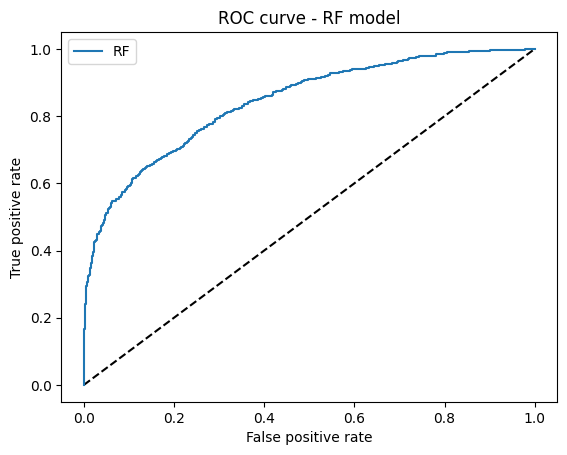

In [29]:
# ROC curve
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - RF model')
plt.legend(loc='best')
plt.show()

In [30]:
X_RF = X.copy()

X_RF = OneHotEncoding(X_RF, enc_ohe, ['Geography'])
X_RF['Gender'] = enc_oe.transform(X_RF[['Gender']])


CreditScore  Gender  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
0          619     0.0   42       2       0.00              1          1   
1          608     0.0   41       1   83807.86              1          0   
2          502     0.0   42       8  159660.80              3          1   
3          699     0.0   39       1       0.00              2          0   
4          850     0.0   43       2  125510.82              1          1   

   IsActiveMember  EstimatedSalary  Geography_France  Geography_Germany  \
0               1        101348.88               1.0                0.0   
1               1        112542.58               0.0                0.0   
2               0        113931.57               1.0                0.0   
3               0         93826.63               1.0                0.0   
4               1         79084.10               0.0                0.0   

   Geography_Spain  
0              0.0  
1              1.0  
2              0.0  
3              0.0  
4              1.0

In [31]:
forest = RandomForestClassifier()
forest.fit(X_RF, y)

importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

print("Feature importance ranking by Random Forest Model:")
for ind in range(X.shape[1]):
  print ("{0} : {1}".format(X_RF.columns[indices[ind]],round(importances[indices[ind]], 4)))

Feature importance ranking by Random Forest Model:
Age : 0.2385
EstimatedSalary : 0.1461
CreditScore : 0.144
Balance : 0.1433
NumOfProducts : 0.1299
Tenure : 0.0828
IsActiveMember : 0.0401
Geography_Germany : 0.0205
Gender : 0.0183
HasCrCard : 0.0173
